# Predicting cancer on rivers dataset

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("data/processed/full_county_dataset.csv")

In [3]:
rivers = data[data.columns[6543:].tolist() + ['recent_trend_cat']].copy()
rivers.head()

,hab_XBKA,hab_MEDBK_A,hab_XUN,hab_MEDBKUN,hab_XCDENMID,hab_XCDENBK,hab_CONPERCENT,hab_PCT_FA,hab_PCT_DR,hab_PCT_FAST,...,bminv_TOTLNIND,bminv_TOTLNTAX,bminv_TRICNTAX,bminv_TRICPIND,bminv_TRICPTAX,bminv_TUBINAIDNTAX,bminv_TUBINAIDPIND,bminv_TUBINAIDPTAX,bminv_WTD_TV,recent_trend_cat
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stable
1,34.535463,30.429749,0.541787,0.386457,50.636641,27.74,0.0,0.0,0.0,0.00,...,300.0,25.50,1.00,0.34,3.22,0.5,1.16,2.50,6.01,rising
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stable
3,44.000000,42.000000,0.010000,0.000000,90.370000,85.96,80.0,0.0,0.0,8.75,...,300.0,42.75,5.25,10.92,12.04,1.5,2.67,3.66,4.80,stable
4,40.330000,31.500000,0.010000,0.000000,40.240000,47.59,70.0,0.0,0.0,27.96,...,300.0,40.00,2.00,1.33,5.00,2.0,9.33,5.00,6.46,stable


In [4]:
rivers.eq(float('inf')).any().any()

True

In [5]:
rivers['recent_trend_cat'].isna().any()

True

There are two things to consider:

- There are values that are infinite. ML models can't deal with those, so will drop columns with infinite values.
- `recent_trend_cat` has missing values. Since this is the `y` variable, any row where this is missing is dropped.

In [6]:
rivers = rivers.loc[rivers['recent_trend_cat'].notna(), rivers.ne(float('inf')).all()]

# Model : Preprocessing

In [7]:
X = rivers.dropna()
y = X.pop('recent_trend_cat')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022, stratify=y)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

# Baseline

In [8]:
y_test.eq(y_train.mode()[0]).mean()

0.815068493150685

# Model 1: Logistic Regression

In [9]:
log = LogisticRegression(penalty='l2', C=0.01, max_iter=10000)
log.fit(Z_train, y_train);

In [10]:
print("Train accuracy =", log.score(Z_train, y_train))
print("Test accuracy  =", log.score(Z_test, y_test))

Train accuracy = 0.8242009132420092
Test accuracy  = 0.815068493150685


# Model 2: Random Forest

In [11]:
rf = RandomForestClassifier(max_depth=1, n_estimators=300, n_jobs=-1)
rf.fit(X_train, y_train);

In [12]:
print("Train accuracy =", rf.score(X_train, y_train))
print("Test accuracy  =", rf.score(X_test, y_test))

Train accuracy = 0.8162100456621004
Test accuracy  = 0.815068493150685


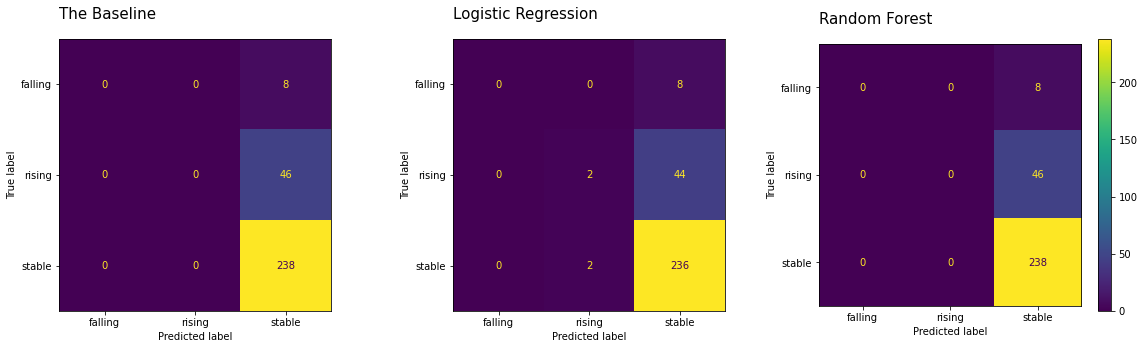

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

ConfusionMatrixDisplay.from_predictions(y_test, pd.Series(y_train.mode()[0], index=y_test.index), ax=axs[0], colorbar=False)
axs[0].set_title("The Baseline", fontsize=15, pad=20, loc='left')

ConfusionMatrixDisplay.from_estimator(log, Z_test, y_test, ax=axs[1], colorbar=False)
axs[1].set_title("Logistic Regression", fontsize=15, pad=20, loc='left')

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=axs[2])
axs[2].set_title("Random Forest", fontsize=15, pad=20, loc='left')

fig.savefig('images/river_cm.png', transparent=True, bbox_inches="tight");